# Create a heatmap of cells-by-position to see if reads concentrate to certain positions

In [ ]:
import glob
import os
import pandas as pd
from tqdm import tqdm
import numpy as np
import pysam
import time
from collections import defaultdict
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
%matplotlib inline
import seaborn as sns
from os.path import join

In [ ]:
from numpanpar import parallel_df as pardf

In [ ]:
BARCODE_INFO = "data/raw/200619_A00953_0124_BHF2LHDSXY/processed/mttrace/mttrace/AD/mapq_0/AD_barcode_data.p"
maxBP = 16571
PILEUP_DIR = "../data/processed/A/A_scPileup_200"
SAVEFIG = "../figures/A/A_MT_heatmap.png"
SAVEFIG_COV = "../figures/A/A_MT_coverage.png"
SAVE_PCT = "../data/processed/A/cell_mt_counts"

## Load CB's, get ones that have over average read coverage of 1x

In [ ]:
[CR_read_number,CB_read_number,BC_read_number, barcodes, corrected_barcodes, barcode_pairs] = pickle.load(open(BARCODE_INFO,"rb"))

In [ ]:
BC_read_number

## Assume read length is 100bp

In [5]:
CB_read_MT = dict()
for i in CB_read_number:
    if CB_read_number[i]*100 >= maxBP:
        CB_read_MT[i] = CB_read_number[i]*100
    
print(len(CB_read_MT))

4713


## Create matrix and load in values from scPileup

In [6]:
def fill_df_coverage(df, pileup_dir, is_par=False):
    not_done = []
    for ind in tqdm(df.index):
        f = glob.glob(os.path.join(pileup_dir,"CB_" + ind + ".coverage.txt"))
        if len(f) == 0:        
            not_done.append(ind)
        else:
            curr = pd.read_csv(f[0], header=None)
            for _, val in curr.iterrows():
                df.loc[ind, val[0]] = val[2]
    print(f"Number of missing files: {len(not_done)}")
    return df

In [6]:
sc_coverage = pd.DataFrame(index=CB_read_MT.keys(),columns= range(1,maxBP+1),dtype=int)
sc_coverage.loc[:,:] = 0
sc_coverage

,1,2,3,4,5,6,7,8,9,10,...,16562,16563,16564,16565,16566,16567,16568,16569,16570,16571
AAACGGGCACGGTAAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AACGTTGGTATTAGCC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAGACCTTCCGTTGTC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACACCAATCTACGAGT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACGGCCAGTAAACGCG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GGGATGAAGGCTAGAC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AGAGCGATCGTCACGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TGGTTAGTCGCGATCG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCTGGAACACAGGCCT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
sc_coverage = pardf(sc_coverage,fill_df_coverage, func_args=(PILEUP_DIR,), num_processes=32)
sc_coverage.to_csv("../data/processed/A/sc_coverage.csv")

#sc_coverage = fill_df_coverage(sc_coverage,PILEUP_DIR)
sc_coverage

100%|██████████| 147/147 [04:24<00:00,  1.80s/it]


74


100%|██████████| 9/9 [00:06<00:00,  1.45it/s]it]]


7


100%|██████████| 147/147 [05:58<00:00,  2.44s/it]


56


100%|██████████| 147/147 [06:05<00:00,  2.49s/it]


47


100%|██████████| 147/147 [07:32<00:00,  3.08s/it]


38


100%|██████████| 147/147 [07:32<00:00,  3.08s/it]


25


100%|██████████| 147/147 [08:15<00:00,  3.37s/it]


36


100%|██████████| 147/147 [08:20<00:00,  3.41s/it]


29


100%|██████████| 147/147 [08:29<00:00,  3.47s/it]


18


100%|██████████| 147/147 [08:39<00:00,  3.53s/it]


15


100%|██████████| 147/147 [08:43<00:00,  3.56s/it]


30


100%|██████████| 147/147 [08:51<00:00,  3.62s/it]


25


100%|██████████| 147/147 [08:59<00:00,  3.67s/it]


20


100%|██████████| 147/147 [09:24<00:00,  3.84s/it]


21


100%|██████████| 147/147 [09:30<00:00,  3.88s/it]


13


100%|██████████| 147/147 [09:47<00:00,  4.00s/it]


21


100%|██████████| 147/147 [10:08<00:00,  4.14s/it]


15


100%|██████████| 147/147 [10:09<00:00,  4.15s/it]


9


100%|██████████| 147/147 [10:30<00:00,  4.29s/it]


16


100%|██████████| 147/147 [10:31<00:00,  4.30s/it]


11


100%|██████████| 147/147 [10:34<00:00,  4.32s/it]


12


100%|██████████| 147/147 [10:43<00:00,  4.38s/it]


11


100%|██████████| 147/147 [11:03<00:00,  4.51s/it]


6


100%|██████████| 147/147 [11:30<00:00,  4.70s/it]


8


100%|██████████| 147/147 [11:57<00:00,  4.88s/it]


9


100%|██████████| 147/147 [12:01<00:00,  4.91s/it]


6


100%|██████████| 147/147 [12:17<00:00,  5.01s/it]


6


100%|██████████| 147/147 [13:17<00:00,  5.43s/it]


6


100%|██████████| 147/147 [14:17<00:00,  5.84s/it]


4


100%|██████████| 147/147 [14:44<00:00,  6.02s/it]


2


100%|██████████| 147/147 [16:04<00:00,  6.56s/it]


4


100%|██████████| 147/147 [17:12<00:00,  7.02s/it]


2


100%|██████████| 147/147 [18:14<00:00,  7.44s/it]


0


,1,2,3,4,5,6,7,8,9,10,...,16562,16563,16564,16565,16566,16567,16568,16569,16570,16571
AAACGGGCACGGTAAG-1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0
AACGTTGGTATTAGCC-1,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,5.0,5.0,5.0,5.0,4.0,4.0,4.0,4.0,0.0,0.0
AAGACCTTCCGTTGTC-1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACACCAATCTACGAGT-1,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,9.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0
ACGGCCAGTAAACGCG-1,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GGGATGAAGGCTAGAC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AGAGCGATCGTCACGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TGGTTAGTCGCGATCG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCTGGAACACAGGCCT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Load sc coverage

In [7]:
sc_coverage = pd.read_csv("../data/processed/A/sc_coverage.csv", index_col=0)

In [8]:
not_done = sc_coverage[((sc_coverage==0).all(axis=1))].index
print(len(not_done))

602


### Remove the indices that are all 0s

In [9]:
sc_coverage = sc_coverage[~(sc_coverage.index.isin(not_done))]

## Plot distributions

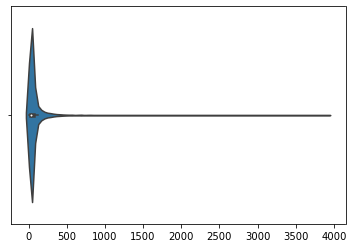

In [11]:
sns.violinplot(sc_coverage.max(axis=1))

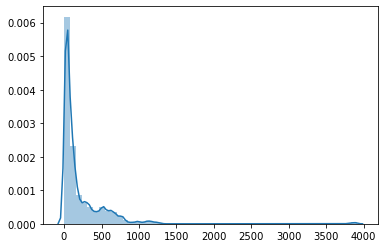

In [12]:
sns.distplot(sc_coverage.max(axis=0))

### log2 coverage

In [10]:
log2_sc_coverage = np.log2(sc_coverage+1)

## Look at the top 500 cells by coverage and plot heatmap# 500

In [13]:
top500 = sc_coverage.loc[sc_coverage.sum(axis=1).sort_values(ascending=False)[:500].index]
#sns.clustermap(top500, col_cluster=False)

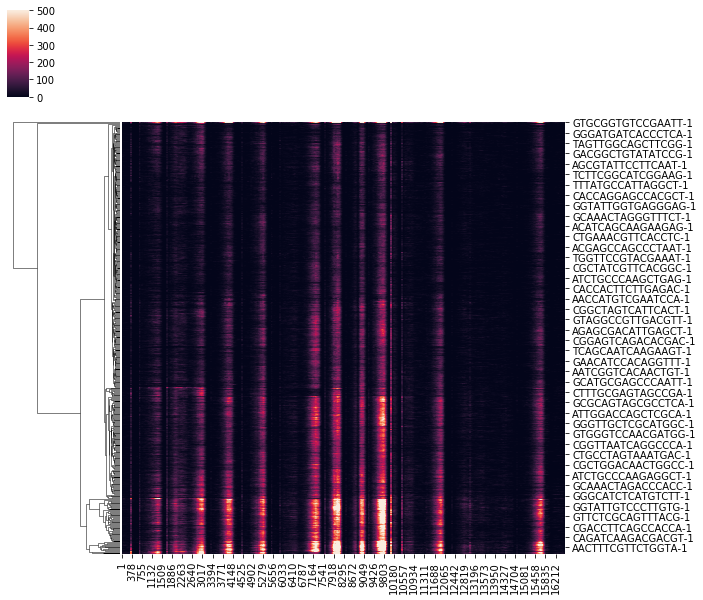

In [14]:
sns.clustermap(top500, col_cluster=False, vmax=500)

## Using log2 helps resolve a lot of this

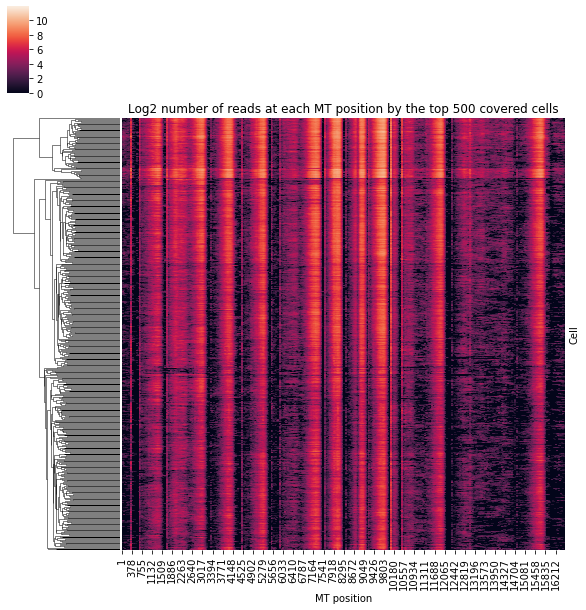

In [15]:
log2_top500 = log2_sc_coverage.loc[log2_sc_coverage.sum(axis=1).sort_values(ascending=False)[:500].index]
g = sns.clustermap(log2_top500, col_cluster=False)
g.ax_heatmap.set_title("Log2 number of reads at each MT position by the top 500 covered cells")
g.ax_heatmap.set_yticks([])
g.ax_heatmap.set_xlabel("MT position")
g.ax_heatmap.set_ylabel("Cell")

plt.savefig(SAVEFIG)

## Plotting the whole matrix has too many 0s that it looks empty, in regular and in log2

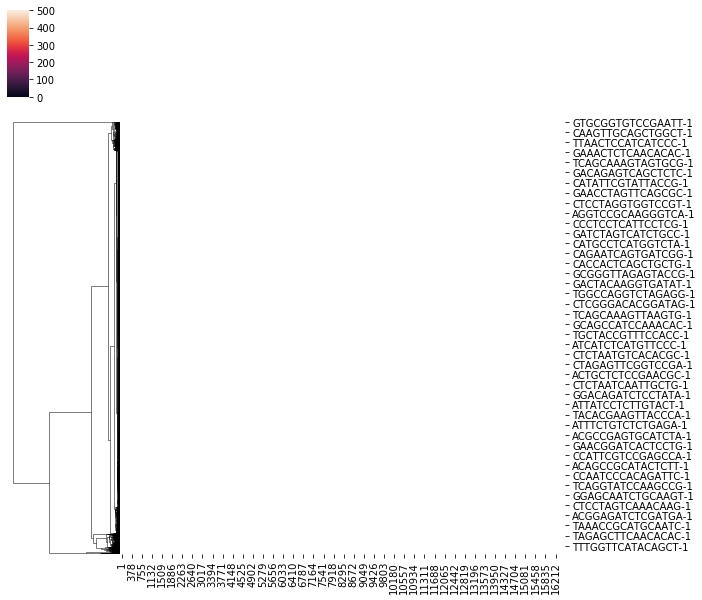

In [16]:
sns.clustermap(sc_coverage, col_cluster=False, vmax=500)

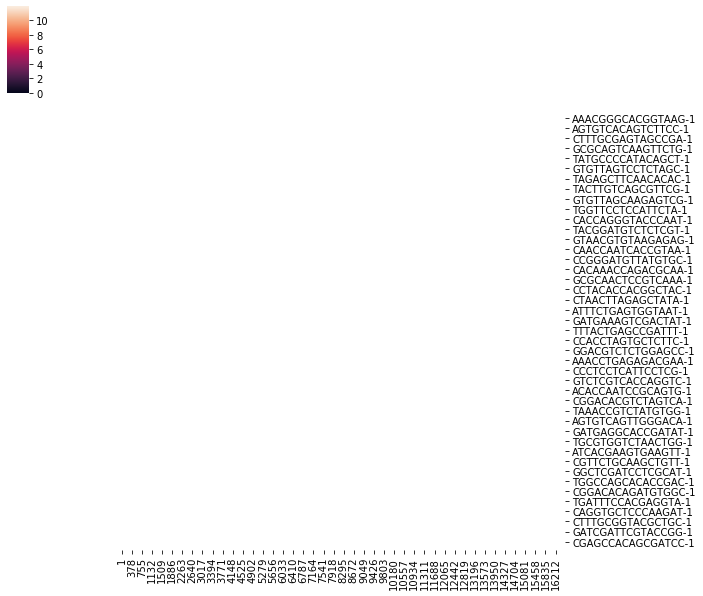

In [17]:
sns.clustermap(log2_sc_coverage, col_cluster=False, row_cluster=False)

## Look at the top 100 cells by coverage and plot heatmap

In [18]:
top100 = sc_coverage.loc[sc_coverage.sum(axis=1).sort_values(ascending=False)[:100].index]

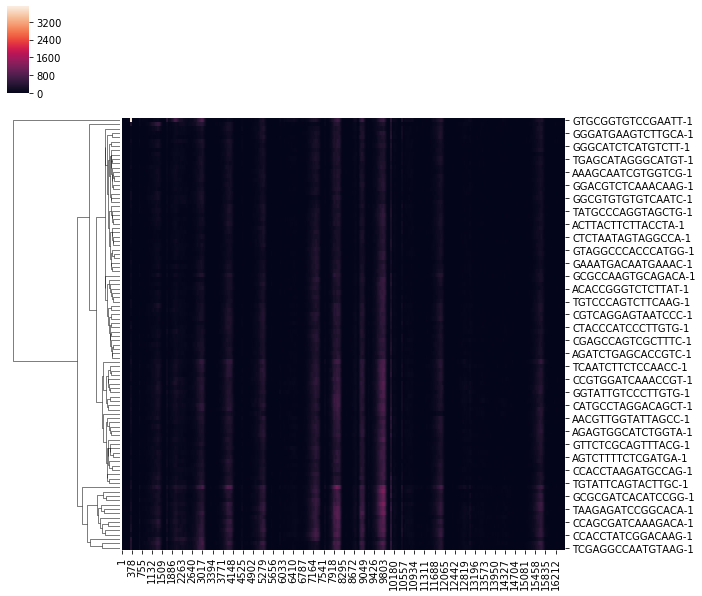

In [19]:
sns.clustermap(top100, col_cluster=False)

## Coverage

In [26]:
cov = sc_coverage.sum(axis=0)
cov = pd.DataFrame(cov, columns=["Coverage"])
cov["Position"] = cov.index
cov["Log2 Coverage"] = np.log2(cov["Coverage"]+1)
cov

,Coverage,Position,Log2 Coverage
1,270.0,1,8.082149
2,296.0,2,8.214319
3,304.0,3,8.252665
4,329.0,4,8.366322
5,344.0,5,8.430453
...,...,...,...
16567,694.0,16567,9.440869
16568,687.0,16568,9.426265
16569,638.0,16569,9.319672
16570,0.0,16570,0.000000


Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x7f12b299e9d8>
Traceback (most recent call last):
  File "/home/isshamie/software/anaconda2/envs/mito_trace/lib/python3.7/site-packages/matplotlib/transforms.py", line 178, in <lambda>
    ref = weakref.ref(self, lambda ref, sid=id(self),
KeyboardInterrupt


 ...]

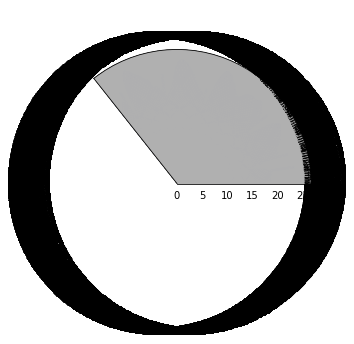

In [44]:

N = len(cov)
bottom = 8
max_height = 4

theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
radii = cov["Log2 Coverage"] #max_height*np.random.rand(N)
width = (2*np.pi) / N


ax = plt.subplot(111, polar=True)
bars = ax.bar(theta, radii, width=width, bottom=bottom)
#labels=cov["Position"].astype(int)

ax.set_xticks(cov["Position"].astype(int))

# Use custom colors and opacity

# for r, bar in zip(radii, bars):
#     bar.set_facecolor(plt.cm.jet(r / 10.))
#     bar.set_alpha(0.8)


# Get coverage at each position

In [10]:
x_cov = [1,2,5,10,30,50,100,200, 1000, 2000, 3000]
cells_cov = [1, 10, 100, 500]
pct_cov = []

pct_cov_df = pd.DataFrame(columns=["Number of MT positions", "Minimum number of cells", 
                                  "Minimum number of reads"])

# for i in x_cov:
#     pct_cov.append((cov["Coverage"] > i).sum())
for x in x_cov:
    curr_count = (sc_coverage >= x).sum(axis=0)
    for c in cells_cov: 
        pct_cov_df = pd.concat((pct_cov_df, pd.DataFrame({"Number of MT positions":(curr_count >= c).sum(),
                                                        "Minimum number of cells": c,
                                                        "Minimum number of reads": x},index=[len(pct_cov_df)])))
    #pct_cov.append((sc_coverage > x).sum(axis=0).sum())


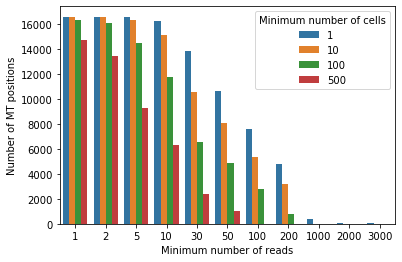

In [11]:
sns.barplot(data=pct_cov_df,x="Minimum number of reads",y="Number of MT positions",hue="Minimum number of cells")
plt.savefig(SAVEFIG_COV)

## Same thing, but with just the top500 cells

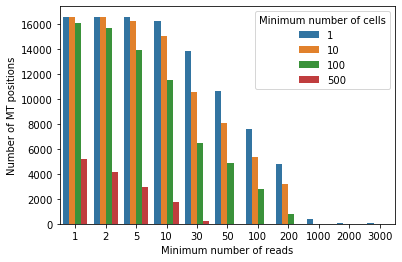

In [13]:
top500 = sc_coverage.loc[sc_coverage.sum(axis=1).sort_values(ascending=False)[:500].index]

x_cov = [1,2,5,10,30,50,100,200, 1000, 2000, 3000]
cells_cov = [1, 10, 100, 500]
pct_cov = []

top500_pct_cov_df = pd.DataFrame(columns=["Number of MT positions", "Minimum number of cells", 
                                  "Minimum number of reads"])

# for i in x_cov:
#     pct_cov.append((cov["Coverage"] > i).sum())
for x in x_cov:
    curr_count = (top500 >= x).sum(axis=0)
    for c in cells_cov: 
        top500_pct_cov_df = pd.concat((top500_pct_cov_df, pd.DataFrame({"Number of MT positions":(curr_count >= c).sum(),
                                                        "Minimum number of cells": c,
                                                        "Minimum number of reads": x},index=[len(top500_pct_cov_df)])))
sns.barplot(data=top500_pct_cov_df,x="Minimum number of reads",y="Number of MT positions",hue="Minimum number of cells")
plt.savefig(SAVEFIG_COV.replace(".png","_top500.png"))

In [17]:
top500_pct_cov_df.to_csv(SAVE_PCT + "_top500" + ".tsv", sep="\t", index=None)